In [1]:
!nvidia-smi  # 查看GPU信息

Sun Feb 23 15:01:34 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:03:00.0 Off |                    0 |
| N/A   43C    P0              60W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from flax import linen as nn

from typing import Sequence

import jax
import jax.numpy as jnp
from jax._src import dtypes

# 正负对称的初始化
def custom_uniform(scale=1e-2, dtype=jnp.float_):
    def init(key, shape, dtype=dtype):
        dtype = dtypes.canonicalize_dtype(dtype)
        return jax.random.uniform(key, shape, dtype, minval=-scale, maxval=scale)
    return init #返回的init输入符合jax接口规范

@jax.jit
def log_cosh(x):
    sgn_x = -2 * jnp.signbit(x.real) + 1
    x = x * sgn_x
    return x + jnp.log1p(jnp.exp(-2.0 * x)) - jnp.log(2.0)

@jax.jit
def attention(J, values, shift):
    values = jnp.roll(values, shift, axis=0)
    return jnp.sum(J * values, axis=0)

class EncoderBlock(nn.Module):
    d_model: int
    num_heads: int
    num_patches: int
    patch_size: int

    def setup(self):
        scale = (3.0 * 0.7 / self.num_patches) ** 0.5

        self.v_projR = nn.Dense(self.d_model, param_dtype=jnp.float64,
                                kernel_init=jax.nn.initializers.variance_scaling(0.1, "fan_in", "uniform"), # 梯度缩放，越小越不容易爆炸，越容易消失
                                bias_init=nn.initializers.zeros)
        self.v_projI = nn.Dense(self.d_model, param_dtype=jnp.float64,
                                kernel_init=jax.nn.initializers.variance_scaling(0.1, "fan_in", "uniform"),
                                bias_init=nn.initializers.zeros)
        
        self.JR = self.param("JR", custom_uniform(scale=scale), (self.num_patches, self.num_heads, 1), jnp.float64)
        self.JI = self.param("JI", custom_uniform(scale=scale), (self.num_patches, self.num_heads, 1), jnp.float64)
        
        self.W0R = nn.Dense(self.d_model, param_dtype=jnp.float64,
                            kernel_init=jax.nn.initializers.variance_scaling(0.065, "fan_in", "uniform"),
                            bias_init=nn.initializers.zeros)
        self.W0I = nn.Dense(self.d_model, param_dtype=jnp.float64,
                            kernel_init=jax.nn.initializers.variance_scaling(0.065, "fan_in", "uniform"),
                            bias_init=nn.initializers.zeros)

    def __call__(self, x):
        J = self.JR + 1j * self.JI
        x = self.v_projR(x).reshape(self.num_patches, self.num_heads, -1) + 1j * self.v_projI(x).reshape(self.num_patches, self.num_heads, -1)
        x = jax.vmap(attention, (None, None, 0))(J, x, jnp.arange(self.num_patches))
        x = x.reshape(self.num_patches, -1)
        x = self.W0R(x) + 1j * self.W0I(x)
        return log_cosh(x)

class Transformer_Enc(nn.Module):
    d_model: int
    num_heads: int
    num_patches: int
    patch_size: int
    n_layers: int  # added parameter to specify number of layers

    def setup(self):
        self.encoders = [
            EncoderBlock(self.d_model, self.num_heads, self.num_patches, self.patch_size)
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        x = x.reshape(x.shape[0], -1, self.patch_size)
        for encoder in self.encoders:
            x = jax.vmap(encoder)(x)
        return jnp.sum(x, axis=(1, 2))

In [ ]:
import jax
import jax.numpy as jnp
import netket as nk
import time
from netket.experimental.driver.vmc_srt import VMC_SRt
from netket.nn.blocks import SymmExpSum


import os
# Set CUDA environment variables
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

# 设置物理系统参数与配置
seed = 0  # 随机数生成器的种子，用于保证结果的可重复性



# 设置优化参数
diag_shift = 1e-3  # 对角线偏移量，用于稳定优化过程
eta = 0.005  # 学习率，控制每次参数更新的步长
N_opt = 10000  # 优化迭代次数，即优化过程中的最大迭代次数
N_samples = 2**12 # 采样数量，即每次迭代中生成的样本数量
N_discard = 0  # 丢弃的采样数量，用于热化过程

# 设置波函数参数
f = 6  # 缩放因子，用于控制嵌入维度
heads = 12 # 注意力头的数量，即多头注意力机制中的头数
d_model = f * heads  # 嵌入维度，即每个注意力头的维度
patch_size = 4  # 块大小，用于将输入序列分块处理
n_layers = 1  # 编码器层数，即Transformer中的层数

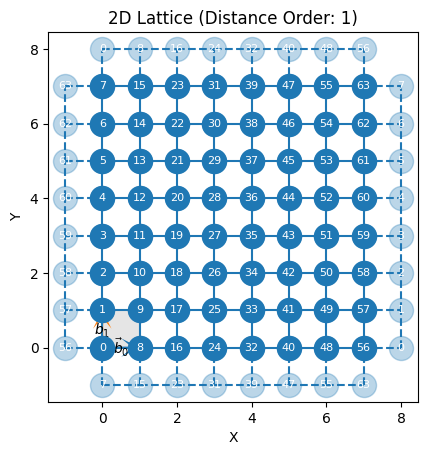

In [4]:
# 设置2D晶格的参数
L = 8 # 晶格长度，即晶格中包含的节点数
N = L * L  # 晶格中的节点总数
J2 = 0.55  # 下一个最近邻相互作用的耦合常数，表示相邻节点之间的相互作用强度

# 创建2D晶格
lattice = nk.graph.Grid(extent=[L, L], pbc=[True, True], max_neighbor_order=2)

lattice.draw() 

# 创建Hilbert空间
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 创建哈密顿量
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=lattice, J=[1.0, J2])

In [5]:
import netket as nk
from netket.utils.group.planar import D

## 选择对称群：如使用晶格平移或点群对称性
# symm_group = lattice.space_group(D(4))
symm_group = lattice.point_group()

# 构造原始Transformer模型
wf_no_symm = Transformer_Enc(d_model=d_model,
                              num_heads=heads,
                              num_patches=lattice.n_nodes // patch_size,
                              patch_size=patch_size,
                              n_layers=n_layers)

# 选择对称群：如使用晶格平移或点群对称性
# 例如：使用点群 (mirror + rotations) 对称性

# 使用 SymmExpSum 对 transformer 进行对称化
from netket.nn.blocks import SymmExpSum
wf_sym = SymmExpSum(module=wf_no_symm, symm_group=symm_group, character_id=None)


# 初始化随机数生成器
key = jax.random.PRNGKey(seed)  # 创建一个随机数生成器的主键
key, subkey = jax.random.split(key, num=2)  # 分割主键，生成子键

# 初始化变分波函数的参数
params = wf_sym.init(subkey, jnp.zeros((1, lattice.n_nodes)))  # 使用子键初始化变分波函数的参数
init_samples = jnp.zeros((1,))  # 初始化采样数组


# 创建Metropolis局部采样器
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, 
                                        graph=lattice, 
                                        d_max=2, 
                                        n_chains=N_samples, 
                                        sweep_size=lattice.n_nodes
                                        )  # 创建一个Metropolis局部采样器，用于生成样本

# 初始化采样器的随机数生成器
key, subkey = jax.random.split(key, 2)  # 再次分割主键，生成新的子键
sampler_seed = subkey  # 将子键赋值给采样器的随机数生成器

# 创建变分量子态
vstate = nk.vqs.MCState(sampler=sampler, 
                        model=wf_sym, 
                        sampler_seed=sampler_seed, 
                        n_samples=N_samples, 
                        n_discard_per_chain=N_discard, 
                        variables=params,
                        chunk_size=2**10
                        )  # 创建一个变分量子态，用于存储变分波函数和采样器的状态

print('Number of parameters = ', nk.jax.tree_size(vstate.parameters))  # 输出变分波函数的参数数量

Number of parameters =  11616


In [6]:
# # 创建变分蒙特卡洛驱动器
import optax

# 创建梯度裁剪器
clipper = optax.clip_by_global_norm(1.0)

# 创建优化器
optimizer = optax.chain(
    clipper,
    optax.sgd(learning_rate=eta)
)

# optimizer = nk.optimizer.Adam(learning_rate=eta)  # 创建一个Adam优化器
vmc = VMC_SRt(hamiltonian=hamiltonian, optimizer=optimizer, diag_shift=diag_shift, variational_state=vstate)  # 创建一个变分蒙特卡洛驱动器，用于优化变分波函数

In [ ]:
import numpy as np
import time

energy_list = []
def check_energy(step, log_data, driver):
    energy = driver.state.expect(hamiltonian).mean
    energy_list.append(energy)
    if np.isnan(energy):
        print(f"NaN energy detected at step {step}")
        driver.stop_training = True
        return False
    return True

try:
    start = time.time()
    # 注意：不再传入 out 参数，即不进行磁盘写入，仅调试使用
    vmc.run(n_iter=N_opt, callback=check_energy)
    end = time.time()
    
    last_energy = energy_list[-1] if energy_list else None
    if last_energy is not None:
        print(f'The optimized energy is E0 = {last_energy / (4*N)}')
    print(f'The calculation took {end - start} seconds')
    
except Exception as e:
    print(f"Error during optimization: {str(e)}")
    raise

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# 使用 energy_list 中的数据绘制能量迭代图
iters_ViT = list(range(len(energy_list)))
# 因为之前保存的 energy 为总能量，所以进行归一化处理
energy_ViT = [e / (4*N) for e in energy_list]

print('J2 = ', J2)
print('The optimized ViT energy is E0 = ', np.real(energy_ViT[-1]))

if L <= 4:
    # 计算基态能量（仅在小系统下计算）
    evals = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=False)
    exact_gs_energy = evals[0] / (4*N)
    print('Exact ground-state energy E0 = ', exact_gs_energy)

    relative_errors = [abs((e - exact_gs_energy) / exact_gs_energy) for e in energy_ViT]
    final_relative_error = relative_errors[-1]
    print('Final relative error = ', final_relative_error)

fig, ax1 = plt.subplots()
ax1.plot(iters_ViT, energy_ViT, color='C8', label='ViT')
ax1.set_ylabel('E/N')
ax1.set_xlabel('Iteration')
ax1.set_title(f'Energy iteration (L={N})')

if 'exact_gs_energy' in globals():
    # 绘制参考的基态能量横线
    ax1.axhline(y=exact_gs_energy, color='k', linewidth=2, linestyle='--', label='Exact')

ax1.legend()
ax1.relim()
ax1.autoscale_view()  # 自动调整上下限
plt.show()
